# Parallel PPO with discrete actions and MLP

In [5]:
%load_ext autoreload
%autoreload 2

You can skip training and instead load the last trained policy by changing the flag below.

In [6]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

In [7]:
from navground.learning import DefaultObservationConfig
from navground.learning.parallel_env import make_vec_from_penv
from navground.learning.config.discrete_control_action_with_comm import DiscreteControlActionWithCommConfig
from navground.learning.examples.pad import get_env, comm, marker, PadReward
from stable_baselines3.common.vec_env import VecMonitor

name = "DistributedCommDiscrete"

comm_size = 1
action = DiscreteControlActionWithCommConfig(use_acceleration_action=True, max_acceleration=1, 
                                             fix_orientation=True, comm_size=comm_size)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)
sensors = [comm(size=comm_size), marker()]
train_env = get_env(action=action, observation=observation, 
                    sensors=sensors, start_in_opposite_sides=True, 
                    reward=PadReward(neighbor_weight=0.5))
train_venv = VecMonitor(make_vec_from_penv(train_env, num_envs=4))
test_env = get_env(action=action, observation=observation, 
                   sensors=sensors, start_in_opposite_sides=True)
test_venv = VecMonitor(make_vec_from_penv(test_env, num_envs=4))

In [8]:
test_venv.action_space

Discrete(6)

In [9]:
%%skip_if $training

import pathlib, os
from stable_baselines3 import SAC

log = max(pathlib.Path(f'logs/{name}/PPO').glob('*'), key=os.path.getmtime)

In [10]:
%%run_if $training

from stable_baselines3 import PPO
from datetime import datetime as dt
from stable_baselines3.common.logger import configure
from navground.learning.utils.sb3 import callbacks
from navground.learning.scenarios.pad import render_kwargs

model = PPO("MultiInputPolicy", train_venv, verbose=0, n_steps=1024)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log = f"logs/{name}/PPO/{stamp}"
model.set_logger(configure(log, ["csv", "tensorboard"]))
kwargs = render_kwargs(comm=True, low=0, high=1, binarize=False,
                       color_low=(1, 0, 0), color_high=(0, 1, 0))
cbs = callbacks(venv=test_venv, best_model_save_path=log, 
                eval_freq=500, export_to_onnx=True, **kwargs)
log

'logs/DistributedCommDiscrete/PPO/20250521_152224'

In [11]:
%%run_if $training

model.learn(total_timesteps=1_000_000, reset_num_timesteps=False, 
            log_interval=1, callback=cbs)
model.num_timesteps

  0%|          | 0/1000000 [00:00<?, ?it/s]

1007616

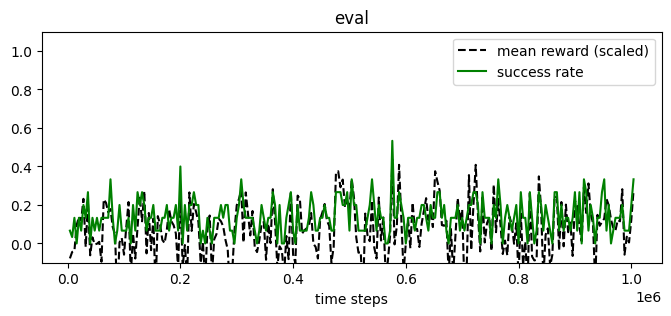

In [12]:
from navground.learning.utils.sb3 import plot_eval_logs

plot_eval_logs(log, reward_low=-200, reward_high=0, success=True, figsize=(8, 3))

In [13]:
from stable_baselines3.common.evaluation import evaluate_policy

best_model = PPO.load(f'{log}/best_model')
evaluate_policy(best_model.policy, test_venv, n_eval_episodes=100)

(-189.48566, 115.6)

In [15]:
from navground.learning.evaluation.video import display_episode_video

display_episode_video(test_env, policy=best_model.policy, factor=4, seed=1, **kwargs)

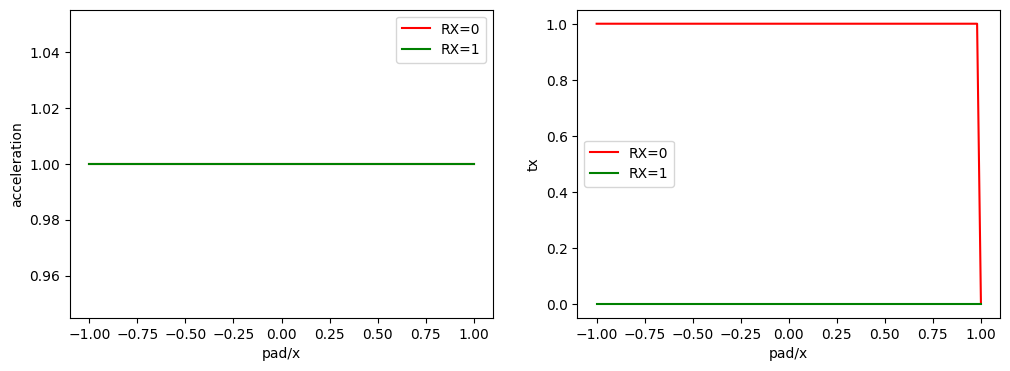

In [17]:
from matplotlib import pyplot as plt
import numpy as np

xs = np.linspace(-1, 1, 101, dtype=np.float32)
xv = np.concatenate([xs, xs])
yv = np.array([0] * 101 + [1] * 101, dtype=np.float32)
obs = {'pad/x': xv.reshape(-1, 1), 
       'neighbor/comm': yv.reshape(-1, 1),
       'ego_velocity': np.full((101, 2), 0.07, dtype=np.float32)}
act, _ = best_model.predict(obs, deterministic=True)
act = act.reshape(2, 101)
acc = act % 3 - 1
comm = act // 3
act = np.stack([acc, comm], axis=-1)
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for i, (ax, t) in enumerate(zip(axs, ('acceleration', 'tx'))):
    if i == 1:
        ax.plot(xs, (act[0, ..., i] > 0).astype(int), label="RX=0", color='red')
        ax.plot(xs, (act[1, ..., i] > 0).astype(int), label="RX=1", color='green')
    else:
        ax.plot(xs, act[0, ..., i], label="RX=0", color='red')
        ax.plot(xs, act[1, ..., i], label="RX=1", color='green')
    ax.set_xlabel('pad/x')
    ax.set_ylabel(t)
    ax.legend()

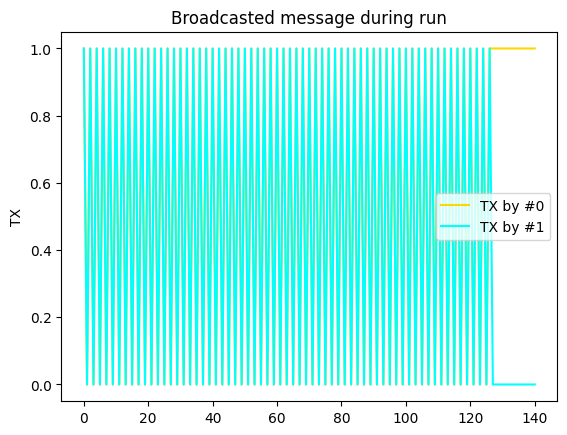

In [20]:
from navground.learning.evaluation.experiment import make_experiment_with_env
from navground.learning.probes.comm import CommProbe
from matplotlib import pyplot as plt
import numpy as np

exp = make_experiment_with_env(test_env, policy=best_model.policy, record_reward=True)
exp.record_config.pose = True
exp.add_record_probe('tx', CommProbe)
exp.number_of_runs = 1
run = exp.run_once(seed=1)
plt.figure(figsize=(8, 3))
for i, color in enumerate(('gold', 'cyan')):
    plt.plot(np.asarray(run.records['tx'])[:, i, 0], color=color, label=f"TX by #{i}")
plt.legend()
plt.ylabel("TX")
plt.title("Broadcasted message during run");